In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import sys
from meta_model.utils import ndcg_sim, ndcg, custom_sim
import matplotlib.pyplot as plt
from metrics import base_metrics
sys.path.append("meta_model")

In [25]:
9, 35, 49, 186, 188

(9, 35, 49)

In [110]:
for filename in os.listdir("meta_dataset_creation/data/benchmark_results_prev/fasterpam/original/scores/"):
    data_id = filename.split(".")[0]
    with open(f"meta_dataset_creation/data/benchmark_results_prev/fasterpam/original/scores/{data_id}.pickle", "rb") as f:
        scores = pickle.load(f)
    if max([max([obj['score'] for obj in scores[p]["acc"]]) for p in scores]) - max([obj['score'] for obj in scores["euclidean_hamming"]["acc"]]) > 0.2:
        print(data_id)

35
1121
41004
987
40978


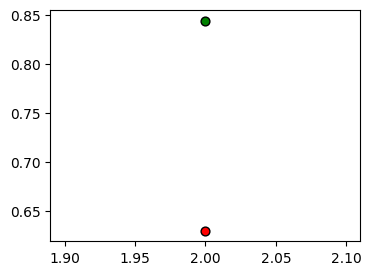

In [101]:
data_id = 1121
with open(f"datasets/mixed/original/{data_id}.pickle", "rb") as f:
    data = pickle.load(f)
with open(f"meta_dataset_creation/data/benchmark_results_prev/fasterpam/original/scores/{data_id}.pickle", "rb") as f:
    scores = pickle.load(f)

eval_metric = "sil"
baseline_pairs = 'euclidean_hamming'
best_pair = sorted(
    scores.keys(),
    key= lambda p: -max([obj['score'] for obj in scores[p][eval_metric] \
        if 0.1 <= obj['params']['alpha'] <= 0.9])
)[0]
colors = {baseline_pairs:"red", best_pair:"green"}
plt.figure(figsize=(4, 3))
for sim_pair in [baseline_pairs, best_pair]:
    y = {}
    for obj in scores[sim_pair][eval_metric]:
        if 0.1 <= obj['params']['alpha'] <= 0.9:
            n_clusters = obj['params']['n_clusters']
            if n_clusters not in y:
                y[n_clusters] = obj['score']
            else:
                y[n_clusters] = max(y[n_clusters], obj['score'])
    plt.plot(y.keys(), y.values(), "--", c=colors[sim_pair], linewidth=0.5)
    plt.scatter(
        y.keys(), y.values(), c=colors[sim_pair],
        s=[20 if n_clusters!=len(set(data["y"])) else 40 for n_clusters in y.keys()],
        edgecolor="black",
        linewidth=[0 if n_clusters!=len(set(data["y"])) else 1 for n_clusters in y.keys()],
        zorder=2
    )
plt.show()

0.9


/homedir/adiop/workspace/simrec-for-mdc/venv/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


0.1


/homedir/adiop/workspace/simrec-for-mdc/venv/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


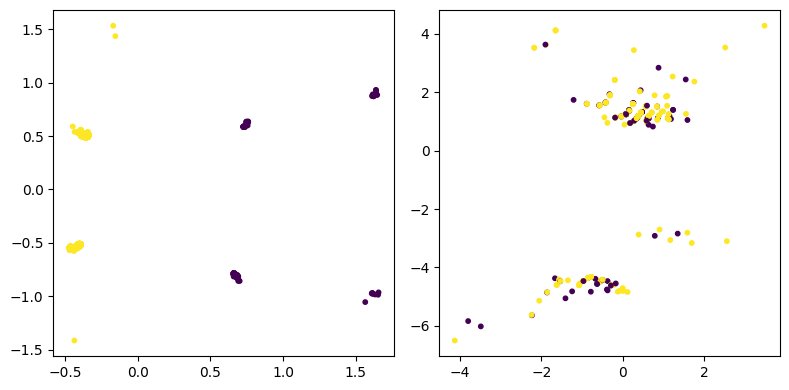

In [102]:
from sklearn.preprocessing import minmax_scale, StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from clustering_algorithms import kmedoids
from sklearn.preprocessing import OneHotEncoder, minmax_scale

plt.figure(figsize=(8, 4))
for i, sim_pair in enumerate([baseline_pairs, best_pair]):
    Dnum = base_metrics.get_metric(sim_pair.split("_")[0]).fit(data["Xnum"]).pairwise(minmax_scale(data["Xnum"]))
    if sim_pair.split("_")[1] in base_metrics.get_available_metrics(data_type="categorical"):
        Dcat = base_metrics.get_metric(sim_pair.split("_")[1]).fit(data["Xcat"]).pairwise(data["Xcat"])
    else:
        enc = OneHotEncoder(handle_unknown='ignore')
        Xdummy = enc.fit_transform(data["Xcat"]).toarray()
        Dcat = base_metrics.get_metric(sim_pair.split("_")[1]).fit(Xdummy).pairwise(Xdummy)
    ind = np.argmax([obj['score'] for obj in scores[sim_pair][eval_metric] if 0.1 <= obj['params']['alpha'] <= 0.9])
    alpha = [obj for obj in scores[sim_pair][eval_metric] if 0.1 <= obj['params']['alpha'] <= 0.9][ind]['params']['alpha']
    print(alpha)
    n_clusters = [obj for obj in scores[sim_pair][eval_metric] if 0.1 <= obj['params']['alpha'] <= 0.9][ind]['params']['n_clusters']
    D = (1-alpha)*Dnum + alpha*Dcat
    # X = TSNE(n_components=2, metric="precomputed", init="random",
    #     learning_rate="auto", n_jobs=-1).fit_transform(D)
    X = MDS(n_components=2, dissimilarity="precomputed", n_jobs=-1).fit_transform(D)
    clusters = kmedoids(Dnum, Dcat, alpha, n_clusters, method="fasterpam")
    plt.subplot(1, 2, i+1)
    plt.scatter(X[:,0], X[:, 1], c=data["y"], s=10) #, data["y"]
plt.tight_layout()
plt.show()

In [121]:
data["Xcat"].shape

(4704, 24)

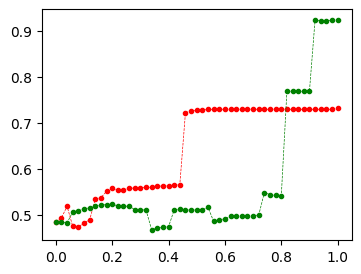

In [119]:
data_id = 41004
with open(f"datasets/mixed/original/{data_id}.pickle", "rb") as f:
    data = pickle.load(f)
with open(f"meta_dataset_creation/data/benchmark_results_prev/fasterpam/original/scores/{data_id}.pickle", "rb") as f:
    scores = pickle.load(f)

eval_metric = "acc"
baseline_pairs = 'euclidean_hamming'
best_pair = sorted(
    scores.keys(),
    key= lambda p: -max([obj['score'] for obj in scores[p][eval_metric]])
)[0]
colors = {baseline_pairs:"red", best_pair:"green"}
plt.figure(figsize=(4, 3))
for sim_pair in [baseline_pairs, best_pair]:
    y = {}
    for obj in scores[sim_pair][eval_metric]:
        alpha = obj['params']['alpha']
        if alpha not in y:
            y[alpha] = obj['score']
        else:
            y[alpha] = max(y[alpha], obj['score'])
    plt.plot(y.keys(), y.values(), "--o", c=colors[sim_pair], markersize=3, linewidth=0.5)
plt.show()

In [122]:
plt.figure(figsize=(8, 4))
for i, sim_pair in enumerate([baseline_pairs, best_pair]):
    Dnum = base_metrics.get_metric(sim_pair.split("_")[0]).fit(data["Xnum"]).pairwise(minmax_scale(data["Xnum"]), n_jobs=-1)
    if sim_pair.split("_")[1] in base_metrics.get_available_metrics(data_type="categorical"):
        Dcat = base_metrics.get_metric(sim_pair.split("_")[1]).fit(data["Xcat"]).pairwise(data["Xcat"], n_jobs=-1)
    else:
        enc = OneHotEncoder(handle_unknown='ignore')
        Xdummy = enc.fit_transform(data["Xcat"]).toarray()
        Dcat = base_metrics.get_metric(sim_pair.split("_")[1]).fit(Xdummy).pairwise(Xdummy, n_jobs=-1)
    ind = np.argmax([obj['score'] for obj in scores[sim_pair][eval_metric]])
    alpha = scores[sim_pair][eval_metric][ind]['params']['alpha']
    print(alpha)
    n_clusters = scores[sim_pair][eval_metric][ind]['params']['n_clusters']
    D = (1-alpha)*Dnum + alpha*Dcat
    # X = TSNE(n_components=2, metric="precomputed", init="random",
    #     learning_rate="auto", n_jobs=-1).fit_transform(D)
    X = MDS(n_components=2, dissimilarity="precomputed", n_jobs=-1).fit_transform(D)
    clusters = kmedoids(Dnum, Dcat, alpha, n_clusters, method="fasterpam")
    plt.subplot(1, 2, i+1)
    plt.scatter(X[:,0], X[:, 1], c=data["y"], s=10, alpha=0.7) #, data["y"]
plt.tight_layout()
plt.show()

1.0


/homedir/adiop/workspace/simrec-for-mdc/venv/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


KeyboardInterrupt: 

<Figure size 800x400 with 0 Axes>

In [ ]:
# from sklearn.preprocessing import minmax_scale, StandardScaler, normalize
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE, MDS
# from scipy.stats import wasserstein_distance
# import matplotlib.pyplot as plt
# df1 = pd.read_csv("meta_dataset_creation/data/meta_features/original/if_meta_features.csv", index_col="id")
# df2 = pd.read_csv("meta_dataset_creation/data/meta_features/from_numeric/if_meta_features.csv", index_col="id")

# meta_X1 = df1.to_numpy()
# meta_X2 = df2.to_numpy()
# # sc = StandardScaler().fit(meta_X1)
# scaled_matrix1 = meta_X1/meta_X1.shape[1] #sc.transform(meta_X1)
# scaled_matrix2 = meta_X2/meta_X2.shape[1] #sc.transform(meta_X2)
# print("Number of meta features1:", meta_X1.shape[1])
# print("Number of instances1:", meta_X1.shape[0])
# print("Number of meta features2:", meta_X2.shape[1])
# print("Number of instances2:", meta_X2.shape[0])
# X = TSNE(n_components=2, metric=wasserstein_distance, init="pca",
#     learning_rate="auto", n_jobs=-1).fit_transform(np.concatenate((scaled_matrix1, scaled_matrix2)))

In [ ]:
# plt.figure(figsize=(5, 5))
# plt.scatter(
#     X[:meta_X1.shape[0], 0], X[:meta_X1.shape[0], 1], s=20,
#     alpha=0.7,
#     linewidth=0,
#     c="green"
# )
# indices = np.random.choice(meta_X2.shape[0], size=500, replace=False) + meta_X1.shape[0]
# plt.scatter(
#     X[indices, 0], X[indices, 1], s=20,
#     alpha=0.7,
#     linewidth=0,
#     c="red"
# )
# plt.xticks([])
# plt.yticks([])
# plt.tight_layout()
# plt.show()

In [ ]:
y1 = np.array([1, 0.95, 0.9, 0.8, 0.7])
y2 = np.array([0.9, 1, 0.95, 0.8, 0.7])
ndcg(y1**4, y2**4)

In [ ]:
benchmark_results = {}
benchmark_results_dir = "meta_dataset_creation/data/benchmark_results/"
clustering_algorithms = os.listdir(benchmark_results_dir)
clustering_algorithms

In [ ]:
for algorithm in clustering_algorithms:
    print(algorithm)
    benchmark_results[algorithm] = {}
    for name in os.listdir(os.path.join(benchmark_results_dir, algorithm)):
        print("\t", name)
        benchmark_results[algorithm][name] = {}
        folder_path = os.path.join(benchmark_results_dir, algorithm, name)
        scores_dir = os.path.join(folder_path, "scores/")
        for filename in os.listdir(scores_dir):
            data_id = filename.split('.')[0]
            with open(os.path.join(scores_dir, filename), "rb") as f:
                result = pickle.load(f)
            for sim_pair in result:
                for eval_metric in result[sim_pair]:
                    if eval_metric not in benchmark_results[algorithm][name]:
                        benchmark_results[algorithm][name][eval_metric] = {}
                    if data_id not in benchmark_results[algorithm][name][eval_metric]:
                        benchmark_results[algorithm][name][eval_metric][data_id] = {}
                    benchmark_results[algorithm][name][eval_metric][data_id][sim_pair] = \
                        max([v["score"] for v in result[sim_pair][eval_metric]])
        for eval_metric in benchmark_results[algorithm][name]:
            benchmark_results[algorithm][name][eval_metric] = \
                pd.DataFrame.from_dict(benchmark_results[algorithm][name][eval_metric], orient='index')
            benchmark_results[algorithm][name][eval_metric] = \
                benchmark_results[algorithm][name][eval_metric].fillna(-1)
            benchmark_results[algorithm][name][eval_metric] = \
                benchmark_results[algorithm][name][eval_metric].replace(-1, -10)
            print(eval_metric, benchmark_results[algorithm][name][eval_metric].shape)
        if len(benchmark_results[algorithm][name]) > 0:
            print()
            max_ = benchmark_results[algorithm][name]["acc"].max(axis=1)
            for eval_metric in ["acc", "ari", "purity"]:
                benchmark_results[algorithm][name][eval_metric] = benchmark_results[algorithm][name][eval_metric][max_ >= 0.7]
                print(eval_metric, benchmark_results[algorithm][name][eval_metric].shape)
            print()

In [ ]:
algorithm = 'kprototypes'
eval_metric = 'acc'
benchmark_results[algorithm]["original"][eval_metric].head()

In [ ]:
benchmark_results[algorithm]["from_numeric"][eval_metric].head()

In [ ]:
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
mixed_meta_df = pd.read_csv("meta_dataset_creation/data/meta_features/original/meta_features.csv", index_col="id").drop_duplicates()
mixed_meta_df.index = mixed_meta_df.index.astype(str)
print("Number of meta features:", mixed_meta_df.shape[1])
print("Number of instances:", mixed_meta_df.shape[0])

In [ ]:
numeric_meta_df = pd.read_csv("meta_dataset_creation/data/meta_features/from_numeric/meta_features.csv", index_col="id").drop_duplicates()
numeric_meta_df.index = numeric_meta_df.index.astype(str)
print("Number of meta features:", numeric_meta_df.shape[1])
print("Number of instances:", numeric_meta_df.shape[0])

In [ ]:
from sklearn.metrics import pairwise_distances
index = benchmark_results[algorithm]["original"][eval_metric].index
mixed_Y = benchmark_results[algorithm]["original"][eval_metric][index.isin(mixed_meta_df.index)].to_numpy()
mixed_Yn = np.array([y/max(y) for y in mixed_Y])
mixed_Yn[mixed_Yn>0] **= 4
mixed_Yn[mixed_Yn<0] = -1

index = benchmark_results[algorithm]["from_numeric"][eval_metric].index
numeric_Y = benchmark_results[algorithm]["from_numeric"][eval_metric][index.isin(numeric_meta_df.index)].to_numpy()
numeric_Yn = np.array([y/max(y) for y in numeric_Y])
numeric_Yn[numeric_Yn>0] **= 4
numeric_Yn[numeric_Yn<0] = -1

# sim_matrix = pairwise_distances(mixed_Yn, metric=lambda y1,y2: ndcg_sim(y1,y2,p=5), n_jobs=-1)
sim_matrix = pairwise_distances(np.concatenate((mixed_Yn, numeric_Yn)), metric=lambda y1,y2: ndcg_sim(y1,y2,p=5), n_jobs=-1)
# sim_matrix = pairwise_distances(Y, metric=lambda y1,y2: custom_sim(y1,y2), n_jobs=-1)

In [ ]:
# np.fill_diagonal(sim_matrix, 0)
# print(mixed_Yn.shape)
# for i, x in enumerate(np.argsort(-sim_matrix[:mixed_Yn.shape[0]], axis=1)[:, :10]):
#     print(x, sim_matrix[i][x])

In [ ]:
index = benchmark_results[algorithm]["original"][eval_metric].index
mixed_X = mixed_meta_df.loc[[i for i in index if i in mixed_meta_df.index]].to_numpy()

index = benchmark_results[algorithm]["from_numeric"][eval_metric].index
numeric_X = numeric_meta_df.loc[[i for i in index if i in numeric_meta_df.index]].to_numpy()
sc = StandardScaler().fit(np.concatenate((mixed_X, numeric_X))) #StandardScaler().fit(mixed_X) #
mixed_X = sc.transform(mixed_X) # mixed_X/mixed_X.shape[1] #
numeric_X = sc.transform(numeric_X) # numeric_X/numeric_X.shape[1] #

mixed_X.shape, numeric_X.shape

In [ ]:
X = np.concatenate((mixed_X, numeric_X))
Y = np.concatenate((mixed_Y, numeric_Y))
Yn = np.concatenate((mixed_Yn, numeric_Yn))

In [ ]:
k = 5
D = pairwise_distances(X, n_jobs=-1)
np.fill_diagonal(D, np.inf)
ndcg_nn_euclidean = []
for i, dist_vec in enumerate(D):
    nearest_neighbors = [j for j in np.argsort(dist_vec) if j != i][:k]
    ndcg_nn_euclidean.append(np.mean(sim_matrix[i][nearest_neighbors]))

# D = pairwise_distances(np.concatenate((mixed_X, numeric_X)), metric=wasserstein_distance, n_jobs=-1)
# np.fill_diagonal(D, np.inf)
# ndcg_nn_wasserstein = []
# for i, dist_vec in enumerate(D):
#     nearest_neighbors = [j for j in np.argsort(dist_vec) if j != i][:k]
#     ndcg_nn_wasserstein.append(np.mean(sim_matrix[i][nearest_neighbors]))

In [ ]:
import matplotlib.pyplot as plt
plt.hist(ndcg_nn_euclidean, 10, density=True, alpha=0.7)
# plt.hist(ndcg_nn_wasserstein, 10, density=True, alpha=0.7)
plt.show()

In [ ]:
# D = pairwise_distances(X)
# np.fill_diagonal(D, np.inf)
nearest_neighbors_distance = np.sort(D, axis=1)[:, :5]
nearest_neighbors_distance = np.mean(nearest_neighbors_distance, axis=1)
median_distance = np.quantile(nearest_neighbors_distance, 0.5)
plt.hist(nearest_neighbors_distance, 50, density=True)
# plt.hist(nearest_neighbors_distance[:mixed_X.shape[0]], 30, density=True)
plt.axvline(median_distance, color="red")
plt.show()
selected_datasets = [i for i in range(mixed_X.shape[0])] # if nearest_neighbors_distance[i] <= median_distance and np.mean(sorted(sim_matrix[i], reverse=True)[:5])>0.95
# if np.mean(sorted(sim_matrix[i], reverse=True)[:3])>0.6 #if np.mean(sorted(sim_matrix[i][np.argsort(D[i])[:30]], reverse=True)[:5])>0.8
selected_datasets = np.array(selected_datasets)
print(len(selected_datasets))
# mixed_X = mixed_X[selected_datasets]
# mixed_Y = mixed_Y[selected_datasets]
# mixed_Yn = mixed_Yn[selected_datasets]

In [ ]:
good_pairs = [[j for j, yj in enumerate(y) if yj/max(y) >= 0.95] for y in Y[selected_datasets]]
dist_matrix = D[selected_datasets][:, selected_datasets]
nearest_neighbors = np.argsort(dist_matrix, axis=1)[:, :5]

for i, neighbors in enumerate(nearest_neighbors):
    reduced_neighbors = [j for j in neighbors if i in nearest_neighbors[j]]
    print([len(set(good_pairs[i]).intersection(set(good_pairs[j]))) for j in reduced_neighbors])

In [ ]:
list(zip(*np.triu_indices(4)))

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import kneighbors_graph
import pygad

g = kneighbors_graph(X[selected_datasets], n_neighbors=5, metric="manhattan").toarray()
g = np.multiply(g, g.T)
sumg = np.sum(g)

def fitness_func(ga_instance, solution, solution_idx):
    s = 0
    for i, j in zip(*np.triu_indices(len(solution))):
        s += 1 if g[i, j] > 0 and solution[i] != solution[j] else 0
    s = 1 - s/sumg
    # n = 1 - len(set(solution))/len(solution)
    return s#(s + n)/ 2

fitness_function = fitness_func

num_generations = 1000
num_parents_mating = 100

sol_per_pop = 100
num_genes = len(selected_datasets)
gene_type = int

gene_space = good_pairs

parent_selection_type = "sss"
keep_elitism = 1
crossover_type = "single_point"
crossover_probability = 0.8
mutation_type = "random"
mutation_probability = 0.2

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       gene_type=gene_type,
                       gene_space=gene_space,
                       parent_selection_type=parent_selection_type,
                       keep_elitism=keep_elitism,
                       crossover_type=crossover_type,
                       crossover_probability=crossover_probability,
                       mutation_type=mutation_type,
                       mutation_probability=mutation_probability,
                    #    parallel_processing=['process', 16],
                    #    save_best_solutions=True
                    )

ga_instance.run()

In [ ]:
ga_instance.plot_fitness()
solution, solution_fitness, solution_idx = ga_instance.best_solution()
s = 0
n_pairs = len(solution)*(len(solution) - 1)/2
for i, j in zip(*np.triu_indices(len(solution))):
    s += 1 if g[i, j] > 0 and solution[i] != solution[j] else 0
print(s/sumg)
print(len(set(solution)))

In [ ]:
similarity_pairs = benchmark_results[algorithm]["original"][eval_metric].columns
print(set(similarity_pairs[solution]))

In [ ]:
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from scipy.stats import wasserstein_distance

Xemb = TSNE(n_components=2, metric="manhattan").fit_transform(X[selected_datasets])
# Xemb = MDS(n_components=2, dissimilarity="precomputed").fit_transform(pairwise_distances(X[selected_datasets], metric="manhattan",n_jobs=-1))

In [ ]:
from matplotlib.colors import TABLEAU_COLORS
l = np.random.choice(list(TABLEAU_COLORS.values()), size=len(set(solution)))
colors = dict(zip(set(solution), l))
plt.figure(figsize=(4, 3))
plt.scatter(
    Xemb[:, 0], Xemb[:, 1],
    s=30, c=[colors[v] for v in solution],
    alpha=0.7
)
# plt.scatter(Xemb[bad, 0], Xemb[bad, 1], s=10, c="red", alpha=0.7)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
from meta_model.ranking import ALL_MODELS
from meta_model.ranking import scorer
import pygad

metrics = ["euclidean", "manhattan", "cosine"]
weights = ["uniform", "distance"]
def fitness_func(ga_instance, solution, solution_idx):
    selected_features = np.array(solution[:X.shape[1]])>0
    n_neighbors = solution[X.shape[1]]
    metric = metrics[solution[X.shape[1]+1]]
    w = weights[solution[X.shape[1]+2]]
    knn = ALL_MODELS["KNN"](n_neighbors=n_neighbors, metric=metric, weights=w)
    fitness = np.mean(cross_val_score(knn, X[selected_datasets][:, selected_features], Y[selected_datasets], cv=5, scoring=scorer))
    return fitness

fitness_function = fitness_func

num_generations = 200
num_parents_mating = 100

sol_per_pop = 100
num_genes = X.shape[1] + 3
gene_type = int

init_range_low = [0 for _ in range(X.shape[1])] + [1, 0, 0]
init_range_high = [1 for _ in range(X.shape[1])] + [20, 2, 1]
gene_space = [[0, 1] for _ in range(X.shape[1])] + [range(1, 21), range(3), [0, 1]]

parent_selection_type = "sss"
keep_elitism = 1
crossover_type = "single_point"
crossover_probability = 0.85
mutation_type = "random"
mutation_probability = 0.1

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       gene_type=gene_type,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       gene_space=gene_space,
                       parent_selection_type=parent_selection_type,
                       keep_elitism=keep_elitism,
                       crossover_type=crossover_type,
                       crossover_probability=crossover_probability,
                       mutation_type=mutation_type,
                       mutation_probability=mutation_probability,
                    #    parallel_processing=['process', 16],
                    #    save_best_solutions=True
                    )

ga_instance.run()

In [ ]:
ga_instance.plot_fitness()

In [ ]:
# # from sklearn.model_selection import cross_val_score
# from meta_model.ranking import scorer
# import pygad

# max_features = [None, "sqrt", "log2"]
# def fitness_func(ga_instance, solution, solution_idx):
#     selected_features = np.array(solution[:X.shape[1]])>0
#     min_samples_leaf = solution[X.shape[1]]
#     max_depth = None if solution[X.shape[1]+1] < 2 else solution[X.shape[1]+1]
#     m = max_features[solution[X.shape[1]+2]]
#     dtree = ALL_MODELS["DTree"](min_samples_leaf=min_samples_leaf, max_depth=max_depth, max_features=m)
#     fitness = np.mean(cross_val_score(dtree, X[selected_datasets][:, selected_features], Y[selected_datasets], cv=5, scoring=scorer))
#     return fitness

# fitness_function = fitness_func

# num_generations = 200
# num_parents_mating = 50

# sol_per_pop = 100
# num_genes = X.shape[1] + 3
# gene_type = int

# init_range_low = [0 for _ in range(X.shape[1])] + [1, 0, 0]
# init_range_high = [1 for _ in range(X.shape[1])] + [20, 10, 2]
# gene_space = [[0, 1] for _ in range(X.shape[1])] + [range(1, 21), range(11), range(3)]

# parent_selection_type = "sss"
# keep_elitism = 1
# crossover_type = "single_point"
# crossover_probability = 0.85
# mutation_type = "random"
# mutation_probability = 0.1

# ga_instance2 = pygad.GA(num_generations=num_generations,
#                        num_parents_mating=num_parents_mating,
#                        fitness_func=fitness_function,
#                        sol_per_pop=sol_per_pop,
#                        num_genes=num_genes,
#                        gene_type=gene_type,
#                        init_range_low=init_range_low,
#                        init_range_high=init_range_high,
#                        gene_space=gene_space,
#                        parent_selection_type=parent_selection_type,
#                        keep_elitism=keep_elitism,
#                        crossover_type=crossover_type,
#                        crossover_probability=crossover_probability,
#                        mutation_type=mutation_type,
#                        mutation_probability=mutation_probability,
#                     #    parallel_processing=['process', 16],
#                     #    save_best_solutions=True
#                     )
# ga_instance2.run()

In [ ]:
# def accept(y1, y2, t):
#     if y2 <= y1:
#         p = 1
#     else:
#         p = 0 if t==0 else np.exp((y1 - y2)/t)
#     return np.random.random() <= p
    
# def heating(fitness, sample_generator, update, N=1000, alpha=1.1, c0=0.8):
#     def f(t):
#         x1 = sample_generator()
#         x2 = update(x1)
#         y1, y2 = fitness(x1), fitness(x2)
#         return 1 if accept(y1, y2, t) else 0

#     t = 0
#     for _ in range(10):
#         x1 = sample_generator()
#         x2 = update(x1)
#         t += abs(fitness(x2) - fitness(x1))/10
        
#     p_accept = 0
#     while p_accept < c0:
#         p_accept = 0
#         for _ in range(N):
#             p_accept += f(t)/N
#         print(t, p_accept)
#         t = alpha*t
#     return t

# def cooling(fitness, sample_generator, update, t0, N=1000, alpha=0.99, tf=1e-4, save_search=False):
#     x1 = sample_generator()
#     y1 = fitness(x1)
#     best_x, best_y = x1, y1
#     if save_search:
#         search_history = {'temperature':[], 'best_y':[], 'y':[]}
#     iter = 0
#     n_iter_wt_improvement = 0
#     t = t0
#     while t > t0*tf and n_iter_wt_improvement < 20:
#         imp = False
#         if save_search:
#             search_history['temperature'].append(t)
#         for _ in range(N):
#             x2 = update(x1)
#             y2 = fitness(x2)
#             if accept(y1, y2, t):
#                 x1, y1 = x2, y2
#             if y2 < best_y:
#                 best_y = y2
#                 best_x = x2
#                 imp = True
#                 n_iter_wt_improvement = 0
        
#         if save_search:
#             search_history['best_y'].append(best_y)
#             search_history['y'].append(y1)

#         t = alpha*t
#         iter += 1
#         if not imp: 
#             n_iter_wt_improvement += 1
#         print("iteration: {}, best_y: {:.3f}".format(iter, best_y))
#     if save_search:
#         return best_x, best_y, search_history
#     return best_x, best_y

In [ ]:
# def select_features(X, Y, k=5):
#     def fitness(x):
#         s = 0
#         D = pairwise_distances(X[:, x>0], n_jobs=-1)
#         for i, dist_vec in enumerate(D):
#             neighbors = [j for j in np.argsort(dist_vec) if j != i][:k]
#             s += ndcg(Y[i], np.mean(Y[neighbors], axis=0))
#             # s += np.mean(ndcg([Y[i]], Y[neighbors]))
#         return -s/X.shape[0]
#     # def fitness(x):
#     #     knn = ALL_MODELS["KNN"]()
#     #     _, s = knn.cross_val_fit(X[:, x>0], Y, return_cv_scores=True)
#     #     return -s

#     def sample_generator():
#         return np.random.randint(2, size=X.shape[1])

#     def update(x):
#         indices = np.random.choice(X.shape[1], size=1) #np.random.randint(5)
#         new_x = np.array(x)
#         new_x[indices] = 1 - new_x[indices]
#         return new_x

#     t0 = heating(fitness, sample_generator, update, N=500)
#     # t0 = 0.0015
#     print("t0: {}".format(t0))
#     best_x, best_y, search_history = cooling(fitness, sample_generator, update, t0, N=500, alpha=0.98, save_search=True)
#     print("best_x: {} best_y: {:.3f}".format(best_x, best_y))
#     import matplotlib.pyplot as plt
#     plt.plot(search_history["best_y"])
#     plt.show()
#     return best_x, best_y
# best_x, best_y = select_features(X, Yn)

In [ ]:
from meta_model.utils import ndcg
from meta_model.ranking import ALL_MODELS
from meta_model.ranking_tree import RankingTree
from sklearn.model_selection import KFold, cross_val_predict

models = {
    "KNN": ALL_MODELS["KNN"](),
    # "DTree": ALL_MODELS["DTree"](),
    # "KNN with FS": ALL_MODELS["KNN"](),
    # "DTree with FS": ALL_MODELS["DTree"](),
}
cv = KFold(n_splits=5)
predictions = {model_name: np.zeros(shape=(len(selected_datasets), 120)) for model_name in models}
predictions["AR"] = np.zeros(shape=(len(selected_datasets), 120))
i = 0

models["KNN"] = models["KNN"].cross_val_fit(X[selected_datasets], Y[selected_datasets], n_splits=5) #
predictions["KNN"] = cross_val_predict(models["KNN"], X[selected_datasets], Y[selected_datasets], cv=cv)
# models["DTree"] = models["DTree"].cross_val_fit(X[selected_datasets], Y[selected_datasets], n_splits=5) #
# predictions["DTree"] = cross_val_predict(models["DTree"], X[selected_datasets], Y[selected_datasets], cv=cv)

# solution, solution_fitness, solution_idx = ga_instance.best_solution()
# selected_features = np.array(solution[:X.shape[1]])>0
# n_neighbors = solution[X.shape[1]]
# metric = metrics[solution[X.shape[1]+1]]
# w = weights[solution[X.shape[1]+2]]
# knn = ALL_MODELS["KNN"](n_neighbors=n_neighbors, metric=metric, weights=w)
# predictions["KNN with FS"] = cross_val_predict(knn, X[selected_datasets][:, selected_features], Y[selected_datasets], cv=cv)

# solution, solution_fitness, solution_idx = ga_instance2.best_solution()
# selected_features = np.array(solution[:X.shape[1]])>0
# min_samples_leaf = solution[X.shape[1]]
# max_depth = None if solution[X.shape[1]+1] < 2 else solution[X.shape[1]+1]
# m = max_features[solution[X.shape[1]+2]]
# dtree = ALL_MODELS["DTree"](min_samples_leaf=min_samples_leaf, max_depth=max_depth, max_features=m)
# predictions["DTree with FS"] = cross_val_predict(dtree, X[selected_datasets][:, selected_features], Y[selected_datasets], cv=cv)

for train, test in cv.split(X[selected_datasets]):
    predictions["AR"][test] = np.array([
        [np.mean([v for v in Y[selected_datasets][train, j]]) for j in range(Y.shape[1])]
        for _ in test
    ])

In [ ]:
sum(solution[:-3]>0)

In [ ]:
mixed_meta_df.columns[features]

In [ ]:
sim_pair = np.argmax(mixed_Y[0]) #sim_pairs_index["manhattan_hamming"]
features = [i for i, v in enumerate(selected_features) if v]
n_rows = len(features)
n_cols = len(features)
plt.figure(figsize=(2*n_cols, 2*n_rows))
for i in range(n_rows - 1):
    for j in range(i+1, n_cols):
        plt.subplot(n_rows, n_cols, i*n_cols + j + 1)
        plt.scatter(mixed_X[:,features[i]], mixed_X[:,features[j]], c=sim_matrix[0, :mixed_X.shape[0]], cmap="YlOrRd", vmin=0., vmax=1)
        # plt.scatter(mixed_X[:,features[i]], mixed_X[:,features[j]], c=sim_matrix[0, :mixed_X.shape[0]], cmap="YlOrRd", vmin=0.5, vmax=1)
        plt.xticks([])
        plt.yticks([])
plt.tight_layout(h_pad=0, w_pad=0)
plt.show()

In [ ]:
import torch
import torch.nn as nn
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
print("device:", device)

class View(nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(*self.shape)

In [ ]:
from metric_learning import ContrastiveML
import ranking
from sklearn.metrics import pairwise_distances

class MetaModel():
    def __init__(self, mapping_function=None, ranking_model="KNN", margin=1, device="cpu"):
        self.metric_learner = None if mapping_function is None else \
            ContrastiveML(mapping_function, margin)
        self.ranker = ranking.ALL_MODELS[ranking_model]()
        self.device = device

    def _create_similarity_matrix(self, Y1, Y2=None):
        return pairwise_distances(Y1, Y2, metric=lambda y1,y2: ndcg_sim(y1,y2,p=5), n_jobs=-1)
        # return pairwise_distances(Y1, Y2)
        # return pairwise_distances(Y1, Y2, metric=lambda y1, y2: custom_sim(y1, y2), n_jobs=-1)

    def train_metric_learner(self, X_train, Y_train, metric_learning_params, X_test=None, Y_test=None):
        if self.metric_learner is None:
            return self
        sim_matrix = self._create_similarity_matrix(Y_train)
        X1, X2, y = [], [], []
        for i in range(X_train.shape[0]-1):
            for j in range(i+1, X_train.shape[0]):
                X1.append(X_train[i])
                X2.append(X_train[j])
                similar = sim_matrix[i, j] > 0.95
                y.append(0 if similar else 1)
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        print()
        print("classes distribution in train set:", np.unique(y, return_counts=True))
        train_dataset = torch.utils.data.TensorDataset(
            torch.tensor(X1, device=self.device).float(),
            torch.tensor(X2, device=self.device).float(),
            torch.tensor(y, device=self.device).float()
        )
        test_dataset = None
        if X_test is not None:
            sim_matrix = self._create_similarity_matrix(Y_test, Y_train)
            X1, X2, y = [], [], []
            for i in range(X_test.shape[0]):
                for j in range(X_train.shape[0]):
                    X1.append(X_test[i])
                    X2.append(X_train[j])
                    similar = sim_matrix[i, j] > 0.95
                    y.append(0 if similar else 1)
            X1, X2, y = np.array(X1), np.array(X2), np.array(y)
            print()
            print("classes distribution in test set:", np.unique(y, return_counts=True))
            test_dataset = torch.utils.data.TensorDataset(
                torch.tensor(X1, device=self.device).float(),
                torch.tensor(X2, device=self.device).float(),
                torch.tensor(y, device=self.device).float()
            )
        
        self.metric_learner.to(self.device)
        optimizer = torch.optim.Adam(self.metric_learner.parameters(), lr=metric_learning_params["lr"])
        metric_learning_params.pop("lr")
        self.metric_learner.fit(train_dataset, optimizer, test_dataset=test_dataset, **metric_learning_params)
        return self

    # def train_metric_learner(self, X_train, Y_train, metric_learning_params, X_test=None, Y_test=None):
    #     if self.metric_learner is None:
    #         return self
    #     sim_matrix = self._create_similarity_matrix(Y_train)
    #     d = pairwise_distances(X_train)
    #     np.fill_diagonal(d, np.inf)
    #     k = 30
    #     nearest_neighbors = np.argsort(d, axis=1)[:, :k]
    #     X1, X2, y = [], [], []
    #     for i in range(X_train.shape[0]):
    #         l = [j for j in np.argsort(-sim_matrix[i]) if j in nearest_neighbors[i]][:5]
    #         for j in nearest_neighbors[i]:
    #             if j in l:
    #                 X1.append(X_train[i])
    #                 X2.append(X_train[j])
    #                 y.append(0)
    #             elif sim_matrix[i, j] < 0.95:
    #                 X1.append(X_train[i])
    #                 X2.append(X_train[j])
    #                 y.append(1)

    #     X1, X2, y = np.array(X1), np.array(X2), np.array(y)
    #     print()
    #     print("classes distribution in train set:", np.unique(y, return_counts=True))
    #     train_dataset = torch.utils.data.TensorDataset(
    #         torch.tensor(X1, device=self.device).float(),
    #         torch.tensor(X2, device=self.device).float(),
    #         torch.tensor(y, device=self.device).float()
    #     )
    #     test_dataset = None
    #     if X_test is not None:
    #         sim_matrix = self._create_similarity_matrix(Y_test, Y_train)
    #         d = pairwise_distances(X_test, X_train)
    #         nearest_neighbors = np.argsort(d, axis=1)[:, :k]
    #         X1, X2, y = [], [], []
    #         for i in range(X_test.shape[0]):
    #             l = [j for j in np.argsort(-sim_matrix[i]) if j in nearest_neighbors[i]][:5]
    #             for j in nearest_neighbors[i]:
    #                 if j in l:
    #                     X1.append(X_test[i])
    #                     X2.append(X_train[j])
    #                     y.append(0)
    #                 elif sim_matrix[i, j] < 0.95:
    #                     X1.append(X_test[i])
    #                     X2.append(X_train[j])
    #                     y.append(1)
    #         X1, X2, y = np.array(X1), np.array(X2), np.array(y)
    #         print()
    #         print("classes distribution in test set:", np.unique(y, return_counts=True))
    #         test_dataset = torch.utils.data.TensorDataset(
    #             torch.tensor(X1, device=self.device).float(),
    #             torch.tensor(X2, device=self.device).float(),
    #             torch.tensor(y, device=self.device).float()
    #         )
        
    #     self.metric_learner.to(self.device)
    #     optimizer = torch.optim.Adam(self.metric_learner.parameters(), lr=metric_learning_params["lr"])
    #     metric_learning_params.pop("lr")
    #     self.metric_learner.fit(train_dataset, optimizer, test_dataset=test_dataset, **metric_learning_params)
    #     return self

    # def train_metric_learner(self, X_train, Y_train, metric_learning_params, X_val=None, Y_val=None):
    #     if self.metric_learner is None:
    #         return self
    #     k = 3
    #     sim_matrix = self._create_similarity_matrix(Y_train)
    #     np.fill_diagonal(sim_matrix, 0)
    #     nearest_neighbors = np.argsort(-sim_matrix, axis=1)[:, :k]
    #     X1, X2, y = [], [], []
    #     for i in range(X_train.shape[0]):
    #         for j in nearest_neighbors[i]:
    #             X1.append(X_train[i])
    #             X2.append(X_train[j])
    #             y.append(0)
    #     for i in range(X_train.shape[0]-1):
    #         for j in range(i, X_train.shape[0]):
    #             if i not in nearest_neighbors[j] and j not in nearest_neighbors[i]:
    #                 X1.append(X_train[i])
    #                 X2.append(X_train[j])
    #                 y.append(1)
    #     X1, X2, y = np.array(X1), np.array(X2), np.array(y)
    #     print("classes distribution in train set:", np.unique(y, return_counts=True))
    #     train_set = torch.utils.data.TensorDataset(
    #         torch.tensor(X1, device=self.device).float(),
    #         torch.tensor(X2, device=self.device).float(),
    #         torch.tensor(y, device=self.device).float()
    #     )
    #     train_loader = torch.utils.data.DataLoader(train_set, batch_size=metric_learning_params["batch_size_train"])

    #     val_loader = None
    #     if X_val is not None:
    #         sim_matrix = self._create_similarity_matrix(Y_val, Y_train)
    #         nearest_neighbors = np.argsort(-sim_matrix, axis=1)[:, :k]
    #         X1, X2, y = [], [], []
    #         for i in range(X_val.shape[0]):
    #             for j in range(X_train.shape[0]):
    #                 X1.append(X_val[i])
    #                 X2.append(X_train[j])
    #                 y.append(0 if j in nearest_neighbors[i] else 1)
    #         X1, X2, y = np.array(X1), np.array(X2), np.array(y)
    #         print("classes distribution in train set:", np.unique(y, return_counts=True))
    #         val_set = torch.utils.data.TensorDataset(
    #             torch.tensor(X1, device=device).float(),
    #             torch.tensor(X2, device=device).float(),
    #             torch.tensor(y, device=device).float()
    #         )
    #         val_loader = torch.utils.data.DataLoader(val_set, batch_size=metric_learning_params["batch_size_val"])
                    
    #     self.metric_learner.to(self.device)
    #     optimizer = torch.optim.Adam(
    #         self.metric_learner.parameters(),
    #         lr=metric_learning_params["lr"],
    #         weight_decay=metric_learning_params["weight_decay"]
    #     )
    #     self.metric_learner.fit(
    #         train_loader, optimizer, 
    #         val_loader=val_loader,
    #         epochs=metric_learning_params["epochs"]
    #     )

    def embbed(self, X):
        if self.metric_learner is None:
            return X
        with torch.no_grad():
            Z = self.metric_learner(torch.tensor(X, device=self.device).float()).cpu().detach().numpy()
        return Z

    def train_ranker(self, Ztrain, Y_train):
        self.ranker = self.ranker.cross_val_fit(Ztrain, Y_train)
        return self


    def fit(self, X_train, Y_train, metric_learning_params, X_test=None, Y_test=None):
        self.train_metric_learner(X_train, Y_train, metric_learning_params, X_test=X_test, Y_test=Y_test)
        Ztrain = self.embbed(X_train)
        self.train_ranker(Ztrain, Y_train)
        return self

    def predict(self, X):
        return self.ranker.predict(self.embbed(X))

In [ ]:
from metric_learning import AE
import ranking
from sklearn.metrics import pairwise_distances

class MetaModel2():
    def __init__(self, encoder=None, decoder=None, ranking_model="KNN", device="cpu"):
        self.metric_learner = None if encoder is None else \
            AE(encoder, decoder)
        self.ranker = ranking.ALL_MODELS[ranking_model]()
        self.device = device

    def train_metric_learner(self, X_train, metric_learning_params, X_val=None):
        train_set = torch.utils.data.TensorDataset(torch.tensor(X_train, device=self.device).float())
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=metric_learning_params["batch_size_train"])
        
        val_loader = None
        if X_val is not None:
            val_set = torch.utils.data.TensorDataset(torch.tensor(X_val, device=self.device).float())
            val_loader = torch.utils.data.DataLoader(val_set, batch_size=metric_learning_params["batch_size_val"])
        
        self.metric_learner.to(self.device)
        optimizer = torch.optim.Adam(
            self.metric_learner.parameters(),
            lr=metric_learning_params["lr"],
            weight_decay=metric_learning_params["weight_decay"]
        )
        self.metric_learner.fit(
            train_loader, optimizer,
            val_loader=val_loader,
            epochs=metric_learning_params["epochs"]
        )
        return self

    def embbed(self, X):
        if self.metric_learner is None:
            return X
        with torch.no_grad():
            Z = self.metric_learner(torch.tensor(X, device=self.device).float()).cpu().detach().numpy()
        return Z

    def train_ranker(self, Ztrain, Y_train):
        self.ranker = self.ranker.cross_val_fit(Ztrain, Y_train)
        return self


    def fit(self, X_train, Y_train, metric_learning_params, X_test=None, Y_test=None):
        self.train_metric_learner(X_train, Y_train, metric_learning_params, X_test=X_test, Y_test=Y_test)
        Ztrain = self.embbed(X_train)
        self.train_ranker(Ztrain, Y_train)
        return self

    def predict(self, X):
        return self.ranker.predict(self.embbed(X))

In [ ]:
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from scipy.stats import wasserstein_distance

# Xemb = TSNE(n_components=2, metric="manhattan").fit_transform(X)
Xemb = MDS(n_components=2, dissimilarity="precomputed").fit_transform(pairwise_distances(X, metric="manhattan",n_jobs=-1))

In [ ]:
# input = torch.randn(20, 300)
# m = nn.Sequential(
#     View((-1, 1, 300)),
#     nn.Conv1d(1, 64, 3, stride=3, padding=0), #100
#     nn.ReLU(),
#     nn.Conv1d(64, 128, 2, stride=2, padding=0), #50
#     nn.ReLU(),
#     nn.Conv1d(128, 256, 5, stride=5, padding=0), #10
#     # nn.ReLU(),
#     # nn.Flatten(),
#     # nn.Linear(512*10, 1024),
#     # nn.ReLU(),
#     # nn.Linear(1024, 32),
#     # nn.ReLU(),
#     # nn.Linear(256, 32)
# )

# m(input).shape

In [ ]:
sim_pair = np.argmax(mixed_Y[10]) #sim_pairs_index["manhattan_hamming"]
print(sim_pair)
indices = [i for i, y in enumerate(mixed_Y) if y[sim_pair] > 0]
print(len(indices))
plt.figure(figsize=(4, 3))
plt.scatter(
    Xemb[indices, 0], Xemb[indices, 1],
    s=30, c=Y[indices, sim_pair],
    edgecolors=["black" if i < mixed_X.shape[0] else "none" for i in indices],
    linewidth=[1 if i < mixed_X.shape[0] else 0 for i in indices],
    alpha=0.7, vmin=0, vmax=1)
# plt.scatter(Xemb[bad, 0], Xemb[bad, 1], s=10, c="red", alpha=0.7)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
i = selected_datasets[0]
plt.figure(figsize=(4, 3))
plt.scatter(
    Xemb[:, 0], Xemb[:, 1], c=Y[:, 0], s=30, alpha=1, 
    edgecolors=['none' if k!=i else "red" for k in range(Xemb.shape[0])],
    linewidth=[0 if k!=i else 2 for k in range(Xemb.shape[0])],
    vmin=0, vmax=1
)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
np.random.seed(1234)
test_index = np.random.choice(selected_datasets, size=3, replace=False)
# test_index = selected_datasets
train_index = [i for i in range(mixed_X.shape[0]) if i not in test_index]
X_train, X_test = X[train_index], X[test_index]
Y_trainr, Y_testr = Y[train_index], Y[test_index]
Y_trainn, Y_testn = Yn[train_index], Yn[test_index]
embeddings = [Xemb]
network = nn.Sequential(
    nn.Linear(X_train.shape[1], 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 2),
)

# network = nn.Sequential(
#     View((-1, 1, X_train.shape[1])),
#     nn.Conv1d(1, 8, 5, stride=1, padding="same"), #300
#     nn.ReLU(),
#     nn.Conv1d(8, 8, 3, stride=3, padding=0), #100
#     nn.ReLU(),
#     nn.Conv1d(8, 16, 3, stride=1, padding="same"), #100
#     nn.ReLU(),
#     nn.Conv1d(16, 16, 2, stride=2, padding=0), #50
#     nn.ReLU(),
#     nn.Conv1d(16, 32, 3, stride=1, padding=0), #48
#     nn.ReLU(),
#     nn.Conv1d(32, 64, 4, stride=4, padding=0), #12
#     nn.ReLU(),
#     nn.Conv1d(64, 128, 3, stride=3, padding=0), #4
#     nn.ReLU(),
#     nn.Flatten(),
#     nn.Linear(128*4, 32)
#     # nn.ReLU(),
#     # nn.Linear(256, 32)
# )
# network.to(device)
model = MetaModel(network, margin=1, device=device)
# network = nn.Sequential(
#     nn.Linear(X_train.shape[1], 64),
#     nn.ReLU(),
#     nn.Linear(64, 32),
#     nn.ReLU(),
#     nn.Linear(32, 16),
#     # nn.ReLU(),
#     # nn.Linear(16, 8)
# )
# network.to(device)
# decoder = nn.Sequential(
#     # nn.Linear(8, 16),
#     # nn.ReLU(),
#     nn.Linear(16, 32),
#     nn.ReLU(),
#     nn.Linear(32, 64),
#     nn.ReLU(),
#     nn.Linear(64, X_train.shape[1])
# )
# decoder.to(device)
# model = MetaModel2(network, decoder, device=device)

for i in range(1):
    # metric_learning_params = {
    #     "lr": 1e-3,
    #     "weight_decay": 1e-5,
    #     "epochs": 200,
    #     "batch_size_train": 16,
    #     "batch_size_val": 16,
    # }
    # # new_X_train = []
    # # for x in X_train:
    # #     for _ in range(100):
    # #         new_X_train.append(np.random.normal(x, 0.01))
    # # new_X_train = np.array(new_X_train)
    # model.train_metric_learner(
    #     X_train,
    #     metric_learning_params,
    #     X_val=X_test
    # )
    # plt.figure(figsize=(3, 2))
    # plt.plot(model.metric_learner.history["train"]["loss"], label="train loss")
    # plt.plot(model.metric_learner.history["val"]["loss"], "--", label="val loss")
    # plt.legend()
    # plt.show()

    metric_learning_params = {
        "lr": 1e-3,
        "weight_decay": 1e-5,
        "epochs": 150,
        "batch_size_train": 32,
        "batch_size_val": 32,
    }
    j = 67
    model.train_metric_learner(
        X_train, Y_trainn,
        metric_learning_params,
        X_val=X_test, Y_val=Y_testn
    )
    plt.figure(figsize=(3, 2))
    plt.plot(model.metric_learner.history["train"]["loss"], label="train loss")
    plt.plot(model.metric_learner.history["val"]["loss"], "--", label="val loss")
    plt.legend()
    plt.show()

    embeddings.append(model.embbed(mixed_X))
    # embeddings.append(TSNE(n_components=2).fit_transform(model.embbed(mixed_X)))

In [ ]:
rows, cols = len(test_index), len(embeddings)
plt.figure(figsize=(cols*3, rows*2))
for i, ind in enumerate(test_index):
    for j, Z in enumerate(embeddings):
        plt.subplot(rows, cols, i*cols + j + 1)
        plt.scatter(
            Z[:, 0], Z[:, 1], c=sim_matrix[ind][:mixed_X.shape[0]], s=40, alpha=0.7, 
            edgecolors=['none' if k!=ind else "red" for k in range(Z.shape[0])],
            linewidth=[0 if  k!=ind else 1 for k in range(Z.shape[0])],
            vmin=0., vmax=1)
        # plt.colorbar()
        plt.xticks([])
        plt.yticks([])
plt.tight_layout(w_pad=0)
plt.show()

In [ ]:
from sklearn.model_selection import KFold
ranking_model_names = ["KNN", "RF"] #, "KNN with aug.", "RF with aug."
for name in ranking_model_names:
    predictions[f"AE+{name}"] = np.zeros(shape=Y[selected_datasets].shape)

i = 0
for train, test in KFold(n_splits=10, shuffle=True, random_state=0).split(X[selected_datasets]):
    print(i, "---------------------------------------")
    test_index = selected_datasets[test]

    train_index = [i for i in range(mixed_X.shape[0]) if i not in test_index]
    train_index_aug = [i for i in range(X.shape[0]) if i not in test_index]
    X_train, X_test = X[train_index], X[test_index]
    Y_trainr, Y_testr = Y[train_index], Y[test_index]
    Y_trainn, Y_testn = Yn[train_index], Yn[test_index]
    X_train_aug = X[train_index_aug]
    Y_trainr_aug = Y[train_index_aug]
    Y_trainn_aug = Yn[train_index_aug]

    network = nn.Sequential(
        nn.Linear(X_train.shape[1], 16),
        # nn.ReLU(),
        # nn.Linear(16, 8),
        # nn.ReLU(),
        # nn.Linear(8, 4)
    )
    network.to(device)
    decoder = nn.Sequential(
        # nn.Linear(4, 8),
        # nn.ReLU(),
        # nn.Linear(8, 16),
        # nn.ReLU(),
        nn.Linear(16, X_train.shape[1])
    )
    decoder.to(device)
    model = MetaModel2(network, decoder, device=device)
    metric_learning_params = {
        "lr": 1e-3,
        "weight_decay": 0,
        "epochs": 400,
        "batch_size_train": 16,
        "batch_size_val": 16,
    }
    model.train_metric_learner(
        X_train,
        metric_learning_params,
        X_val=X_test
    )

    # plt.figure(figsize=(4, 2.5))
    # plt.plot(model.metric_learner.history["train"]["loss"], label="train loss")
    # plt.plot(model.metric_learner.history["val"]["loss"], "--", label="val loss")
    # plt.legend()
    # plt.show()

    Z_train = model.embbed(X_train)
    for name in ["KNN", "RF"]:
        model.ranker = ALL_MODELS[name]()
        model.train_ranker(Z_train, Y_trainr)
        predictions[f"AE+{name}"][test] = model.predict(X_test)

    # network = nn.Sequential(
    #     nn.Linear(X_train.shape[1], 64),
    #     nn.ReLU(),
    #     nn.Linear(64, 32),
    #     nn.ReLU(),
    #     nn.Linear(32, 16),
    #     # nn.ReLU(),
    #     # nn.Linear(16, 8),
    #     # nn.ReLU(),
    #     # nn.Linear(8, 4)
    # )
    # network.to(device)
    # decoder = nn.Sequential(
    #     # nn.Linear(4, 8),
    #     # nn.ReLU(),
    #     # nn.Linear(8, 16),
    #     # nn.ReLU(),
    #     nn.Linear(16, 32),
    #     nn.ReLU(),
    #     nn.Linear(32, 64),
    #     nn.ReLU(),
    #     nn.Linear(64, X_train.shape[1])
    # )
    # decoder.to(device)
    # model = MetaModel2(network, decoder, device=device)
    # metric_learning_params = {
    #     "lr": 1e-3,
    #     "weight_decay": 1e-4,
    #     "epochs": 250,
    #     "batch_size_train": 16,
    #     "batch_size_val": 16,
    # }
    # model.train_metric_learner(
    #     X_train_aug,
    #     metric_learning_params,
    #     X_val=X_test
    # )

    # # plt.figure(figsize=(4, 2.5))
    # # plt.plot(model.metric_learner.history["train"]["loss"], label="train loss")
    # # plt.plot(model.metric_learner.history["val"]["loss"], "--", label="val loss")
    # # plt.legend()
    # # plt.show()

    # Z_train_aug = model.embbed(X_train_aug)
    # for name in ["KNN with aug.", "RF with aug."]:
    #     model.ranker = ALL_MODELS[name.split(" ")[0]]()
    #     model.train_ranker(Z_train_aug, Y_trainr_aug)
    #     predictions[f"AE+{name}"][test] = model.predict(X_test)
    i += 1

In [ ]:
# from sklearn.model_selection import KFold
# ranking_model_names = ["KNN", "RF"] # , "KNN with aug.", "RF with aug."
# for name in ranking_model_names:
#     predictions[f"Mtrl+{name}"] = np.zeros(shape=Y[selected_datasets].shape)

# i = 0
# for train, test in cv.split(X[selected_datasets]):
#     print(i, "---------------------------------------")
#     test_index = selected_datasets[test]

#     train_index = [i for i in range(mixed_X.shape[0]) if i not in test_index]
#     train_index_aug = [i for i in range(X.shape[0]) if i not in test_index]
#     X_train, X_test = X[train_index][:, selected_features], X[test_index][:, selected_features]
#     Y_trainr, Y_testr = Y[train_index], Y[test_index]
#     Y_trainn, Y_testn = Yn[train_index], Yn[test_index]
#     X_train_aug = X[train_index_aug]
#     Y_trainr_aug = Y[train_index_aug]
#     Y_trainn_aug = Yn[train_index_aug]

#     network = nn.Sequential(
#         nn.Linear(X_train.shape[1], 16),
#         # nn.ReLU(),
#         # nn.Linear(128, 64),
#         # nn.ReLU(),
#         # nn.ReLU(),
#         # nn.Linear(16, 8),
#         # nn.ReLU(),
#         # nn.Linear(8, 4),
#     )
#     network.to(device)
#     model = MetaModel(network, margin=2, device=device)
#     metric_learning_params = {
#         "lr": 1e-3,
#         "weight_decay": 0,
#         "epochs": 400,
#         "batch_size_train": 16,
#         "batch_size_val": 16,
#     }
#     model.train_metric_learner(
#         X_train, Y_trainn,
#         metric_learning_params,
#         X_val=X_test, Y_val=Y_testn
#     )

#     # plt.figure(figsize=(4, 2.5))
#     # plt.plot(model.metric_learner.history["train"]["loss"], label="train loss")
#     # plt.plot(model.metric_learner.history["val"]["loss"], "--", label="val loss")
#     # plt.legend()
#     # plt.show()

#     Z_train = model.embbed(X_train)
#     for name in ["KNN", "RF"]:
#         model.ranker = ALL_MODELS[name]()
#         model.train_ranker(Z_train, Y_trainn)
#         predictions[f"Mtrl+{name}"][test] = model.predict(X_test)

#     ##################################################
#     # network = nn.Sequential(
#     #     nn.Linear(X_train.shape[1], 64),
#     #     nn.ReLU(),
#     #     nn.Linear(64, 32),
#     #     nn.ReLU(),
#     #     nn.Linear(32, 24),
#     #     # nn.ReLU(),
#     #     # nn.Linear(16, 8),
#     #     # nn.ReLU(),
#     #     # nn.Linear(8, 4),
#     # )
#     # network.to(device)
#     # model = MetaModel(network, margin=1, device=device)
#     # metric_learning_params = {
#     #     "lr": 1e-3,
#     #     "weight_decay": 1e-4,
#     #     "epochs": 100,
#     #     "batch_size_train": 256,
#     #     "batch_size_val": 256,
#     # }
#     # model.train_metric_learner(
#     #     X_train_aug, Y_trainn_aug,
#     #     metric_learning_params,
#     #     X_val=X_test, Y_val=Y_testn
#     # )

#     # # plt.figure(figsize=(4, 2.5))
#     # # plt.plot(model.metric_learner.history["train"]["loss"], label="train loss")
#     # # plt.plot(model.metric_learner.history["val"]["loss"], "--", label="val loss")
#     # # plt.legend()
#     # # plt.show()

#     # Z_train_aug = model.embbed(X_train_aug)
#     # for name in ["KNN with aug.", "RF with aug."]:
#     #     model.ranker = ALL_MODELS[name.split(" ")[0]]()
#     #     model.train_ranker(Z_train_aug, Y_trainn_aug)
#     #     predictions[f"Mtrl+{name}"][test] = model.predict(X_test)
#     i+=1

In [ ]:
baseline_pairs = {
    "haverage": "manhattan_hamming",
    "fasterpam": "euclidean_hamming",
    "kprototypes": "sqeuclidean_hamming",
}
similarity_pairs = benchmark_results[algorithm]["original"][eval_metric].columns
sim_pairs_index = dict(zip(similarity_pairs, range(len(similarity_pairs))))

ndcg_ranks = [1, 3, 5, 10, 15, 20]
n_bests = [1, 3, 5, 10]
ndcg_scores = {
    model_name: {p: np.zeros(len(selected_datasets)) for p in ndcg_ranks}
    for model_name in predictions
} #| {'ensemble': {p: np.zeros(meta_X.shape[0]) for p in ndcg_ranks}}

lb_scores = np.zeros(len(selected_datasets))
rb_scores = {k: np.zeros(len(selected_datasets)) for k in n_bests}
mb_scores = np.zeros(len(selected_datasets))
model_scores = {
    model_name: {k: np.zeros(len(selected_datasets)) for k in n_bests}
    for model_name in predictions
} #| {'ensemble': {k: np.zeros(len(test_index)) for k in n_bests}}

for name, Y_pred in predictions.items():
    Y_pred = np.array(Y_pred)
    for p in ndcg_ranks:
        ndcg_scores[name][p] = ndcg(Y[selected_datasets], Y_pred, p=p)

for name, Y_pred in predictions.items():
    Y_pred = np.array(Y_pred)
    for k in n_bests:
        model_scores[name][k] = np.array(
            [max(y[y > 0][np.argsort(-Y_pred[i][y > 0])[:k]]) for i, y in enumerate(Y[selected_datasets])])

for k in n_bests:
    rb_scores[k] = np.array(
        [max(np.random.choice(y[y > 0], k)) for y in Y[selected_datasets]])

lb_scores = Y[selected_datasets][:, sim_pairs_index[baseline_pairs[algorithm]]]
mb_scores = np.array([max(y) for y in Y[selected_datasets]])

In [ ]:
import matplotlib.pyplot as plt

list_indices = [
    [i for i, y in enumerate(Y[selected_datasets]) if np.mean(1 - y[y>0]/max(y[y>0])) < 0.0], #test_index[i] in base_datasets and # i in test and
    [i for i, y in enumerate(Y[selected_datasets]) if np.mean(1 - y[y>0]/max(y[y>0])) >= 0.]
]
rows, cols = 1, len(list_indices)
plt.figure(figsize=(cols*4, rows*3))
subplot_num = 1
exclude = [] #"KNN with aug.", "RF with aug." - "KNN", "RF", "AE+KNN", "AE+RF"
for indices in list_indices:
    scores = {k:v for k, v in model_scores.items() if k not in exclude} 
    # scores["RB"] = rb_scores
    scores["LB"] = lb_scores
    scores["Best"] = mb_scores

    y = {key: [] for key in scores}

    for name, score in scores.items():
        for k in n_bests:
            u = score[indices] if name in ["LB", "Best"] else score[k][indices]
            y[name].append(np.mean(u))

    plt.subplot(rows, cols, subplot_num)
    for name, values in y.items():
        plt.plot(n_bests, values, label=name)
    plt.ylabel("Mean accuracy")
    plt.xlabel("Number of recommended pair")
    # plt.ylim((0.67, 0.9))
    plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1))
    plt.grid(axis="y")
    plt.title(len(indices))
    subplot_num += 1
plt.tight_layout()
# plt.savefig("output/mean_acc2.svg")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

indices = [i for i, y in enumerate(Y[selected_datasets]) if np.mean(1 - y[y>0]/max(y[y>0])) >= 0]

exclude = []
scores = {k:v for k, v in model_scores.items() if k not in exclude} 
# scores["RB"] = rb_scores
scores["LB"] = lb_scores

y = {key: [] for key in scores}
k = 1
best_scores = mb_scores[indices]
for name, score in scores.items():
    u = score[indices] if name in ["LB", "Best"] else score[k][indices]
    y[name] = np.mean(u/best_scores)

plt.figure(figsize=(5, 4))
plt.bar(y.keys(), y.values(), zorder=5)
plt.ylabel("Accuracy")
plt.ylim((0.85, 0.96))
plt.xticks(rotation="vertical")
# plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1))
plt.grid(axis="y")
plt.title(len(indices))
plt.tight_layout()
# plt.savefig("output/mean_acc2.svg")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

indices = [i for i, y in enumerate(Y[selected_datasets]) if np.mean(1 - y[y>0]/max(y[y>0])) >= 0.]

exclude = []
scores = {k:v for k, v in model_scores.items() if k not in exclude} 
# scores["RB"] = rb_scores
scores["LB"] = lb_scores

y = {key: [] for key in scores}
k = 5
best_scores = mb_scores[indices]
for name, score in scores.items():
    u = score[indices] if name in ["LB", "Best"] else score[k][indices]
    y[name] = u/best_scores

plt.figure(figsize=(5, 4))
plt.boxplot(y.values(), labels=y.keys())
plt.ylabel("Accuracy")
# plt.ylim((0.67, 0.9))
plt.xticks(rotation="vertical")
# plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1))
plt.grid(axis="y")
plt.title(len(indices))
plt.tight_layout()
# plt.savefig("output/mean_acc2.svg")
plt.show()